In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
#to ignore warnings
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [108]:
def data_preprocessing_binary(path):
  df = pd.read_csv(path)
  df_encoded = pd.get_dummies(df[['Proto','State']], columns=['Proto', 'State'])

  select_features_df = df[[ 'AckDat', 'sHops', 'Seq','TcpRtt', 'dMeanPktSz', 'Offset', 'sTtl',  'Mean', 'SrcTCPBase', 'sMeanPktSz', 'DstLoss', 'Loss', 'dTtl', 'SrcBytes', 'TotBytes']]
  select_features_df['sHops'].fillna(df['sHops'].mean(), inplace = True)
  select_features_df['sTtl'].fillna(df['sTtl'].mean(), inplace = True)
  select_features_df['SrcTCPBase'].fillna(df['SrcTCPBase'].mean(), inplace = True)
  select_features_df['dTtl'].fillna(df['dTtl'].mean(), inplace = True)
  df_merged = pd.concat([select_features_df, df_encoded], axis=1)

  df_output_encoded = df['Label']
  df_output_encoded_1 = df_output_encoded.replace(['Benign', 'Malicious'],
                        [0, 1], inplace=False)


  #returns input and output dataframe
  return df_merged, df_output_encoded_1



In [109]:
def binary_cnn(X, y):
  import tensorflow as tf
  from tensorflow.keras import layers, models
  from sklearn.model_selection import train_test_split
  import numpy as np
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
  from tensorflow.keras.optimizers import Adam
  from tensorflow.keras.metrics import Precision, Recall
  from sklearn.metrics import f1_score
  import time


  # Assuming df_normalized is your preprocessed DataFrame
  # Assuming df_output_encoded_1 contains the binary labels for classification

  # Split the data into features and labels
  X = X.values  # Features
  y = y.values  # Labels

  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Reshape the input data for CNN (assuming df_normalized has shape (n_samples, n_features))
  input_shape = (X.shape[1], 1)  # Assuming you have n_features columns
  X_train = X_train.reshape(-1, X_train.shape[1], 1)
  X_test = X_test.reshape(-1, X_test.shape[1], 1)

  # Define the CNN architecture
  model = models.Sequential([
      # Convolutional layers
      layers.Conv1D(32, 3, activation='relu', input_shape=input_shape),
      layers.MaxPooling1D(2),
      layers.Conv1D(64, 3, activation='relu'),
      layers.MaxPooling1D(2),
      layers.Conv1D(64, 3, activation='relu'),

      # Dense layers
      layers.Flatten(),
      layers.Dense(64, activation='relu'),
      layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
  ])

  # Compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy', Precision(), Recall()])

  start_time = time.time()
  history = model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_test, y_test))
  end_time = time.time()
  training_time = end_time - start_time

  # Evaluate the model
  loss, accuracy, precision, recall = model.evaluate(X_test, y_test)
  y_pred = model.predict(X_test)
  f1 = f1_score(y_test, y_pred > 0.5)

  # Print metrics
  print("Model Loss:", loss)
  print("Model Accuracy:", accuracy)
  print("Model Precision:", precision)
  print("Model Recall:", recall)
  print("F1 Score:", f1)
  print("Training Time:", training_time)

  return model


In [110]:
def binary_cnn_numpyarr(X, y):
    # Import necessary libraries
    import tensorflow as tf
    from tensorflow.keras import layers, models
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import f1_score
    import time

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Check the shape of X_train
    print("Shape of X_train:", X_train.shape)

    # Reshape the input data for CNN (assuming X has shape (n_samples, n_features))
    input_shape = (X_train.shape[1], 1)  # Assuming you have n_features columns
    X_train = X_train.reshape(-1, X_train.shape[1], 1)
    X_test = X_test.reshape(-1, X_test.shape[1], 1)

    # Define the CNN architecture
    model = models.Sequential([
        # Convolutional layers
        layers.Conv1D(32, 3, activation='relu', input_shape=input_shape),
        layers.MaxPooling1D(2),
        layers.Conv1D(64, 3, activation='relu'),

        # Dense layers
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.metrics.Precision(), tf.metrics.Recall()])

    # Start training time measurement
    start_time = time.time()

    # Train the model
    history = model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_test, y_test))

    # End training time measurement
    end_time = time.time()

    # Calculate training time
    training_time = end_time - start_time

    # Evaluate the model
    loss, accuracy, precision, recall = model.evaluate(X_test, y_test)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred > 0.5)

    # Print metrics
    print("Model Loss:", loss)
    print("Model Accuracy:", accuracy)
    print("Model Precision:", precision)
    print("Model Recall:", recall)
    print("F1 Score:", f1)
    print("Training Time:", training_time)

    return model,X_test, y_test, history

In [111]:
def standardize(input_df):
  scaler = StandardScaler()
  df_standardized = scaler.fit_transform(input_df)
  df_standardized = pd.DataFrame(df_standardized, columns=input_df.columns)
  return df_standardized


In [112]:
from sklearn.impute import SimpleImputer

def normalize_data(input_df):
    # Handling missing values
    imputer = SimpleImputer(strategy='mean')
    input_df_filled = pd.DataFrame(imputer.fit_transform(input_df), columns=input_df.columns)

    # Feature scaling
    scaler = StandardScaler()
    input_scaled = pd.DataFrame(scaler.fit_transform(input_df_filled), columns=input_df.columns)

    return input_scaled


In [113]:
from scipy import stats

def remove_outliers_zscore(input_df, threshold=3):
    z_scores = np.abs(stats.zscore(input_df))
    input_df_no_outliers = input_df[(z_scores < threshold).all(axis=1)]
    return input_df_no_outliers

In [114]:
from sklearn.feature_selection import SelectKBest, f_classif
def select_features(input_df, target, k=10):
    selector = SelectKBest(score_func=f_classif, k=k)
    X_selected = selector.fit_transform(input_df, target)
    selected_features = input_df.columns[selector.get_support()]
    return X_selected, selected_features

In [115]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
import itertools

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = range(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [116]:
from sklearn.metrics import confusion_matrix, auc
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    plot_confusion_matrix(y_test, y_pred, classes=['Benign', 'Malicious'])


In [117]:
path = '/content/drive/MyDrive/5G NIDD/Combined.csv'
input, output = data_preprocessing_binary(path)


In [ ]:
input_standardized = standardize(input)

In [118]:
normalize_data = normalize_data(input)

In [119]:
input_no_outliers = remove_outliers_zscore(normalize_data)

In [120]:
output = output.iloc[input_no_outliers.index]

In [121]:
input_selected, selected_features = select_features(input_no_outliers, output)

In [122]:
print("input_select:",pd.DataFrame(input_selected).head())

input_select:           0         1         2         3         4         5         6  \
0 -0.388022 -0.633309 -1.067890 -0.267943 -1.156827 -0.312123 -0.753952   
1 -0.388022 -0.633309 -1.067599 -0.267943 -1.156715 -0.312123 -0.704226   
2 -0.388022 -0.633309 -1.067387 -0.267943 -1.156590 -0.312123 -0.687375   
3 -0.388022 -0.633309 -1.066990 -0.267943 -1.156403 -0.312123 -0.806443   
4 -0.388022 -0.633309 -1.066963 -0.267943 -1.156355 -0.312123 -0.806003   

          7         8         9  
0 -0.545287  0.588592 -0.608742  
1 -0.545287  0.588592 -0.608742  
2 -0.545287  0.588592 -0.608742  
3 -0.545287  0.588592 -0.608742  
4 -0.545287  0.588592 -0.608742  


In [ ]:
cnn_model = binary_cnn(input_standardized, output)

In [123]:
cnn_model,X_test, y_test, history = binary_cnn_numpyarr(input_selected, output)

Shape of X_train: (738972, 10)
5774/5774 [==============================] - 6s 1ms/step
Model Loss: 0.0017723978962749243
Model Accuracy: 0.9994912147521973
Model Precision: 0.9997044205665588
Model Recall: 0.9993995428085327
F1 Score: 0.9995519499709244
Training Time: 48.88537335395813


5774/5774 [==============================] - 8s 1ms/step


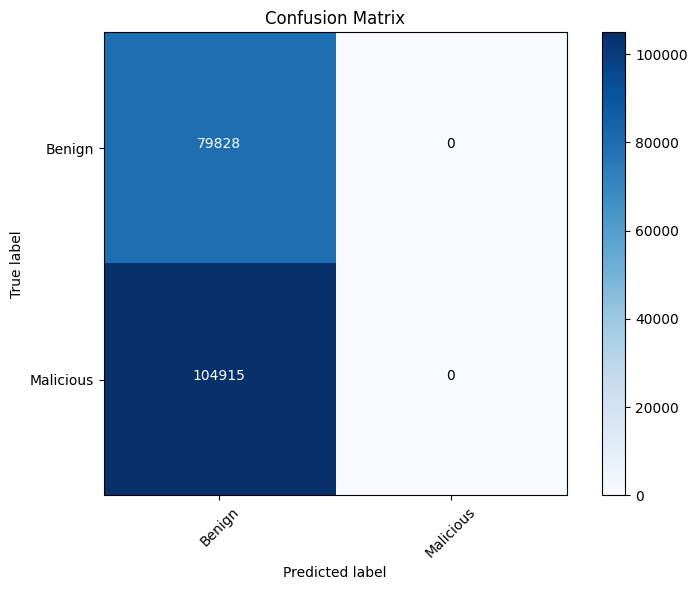

In [124]:
evaluate_model(cnn_model, X_test, y_test)

In [ ]:
def data_preprocessing_multiclass(path):
  from sklearn.preprocessing import LabelEncoder
  df = pd.read_csv(path)
  df_encoded = pd.get_dummies(df[['Proto','State']], columns=['Proto', 'State'])
  df_encoded_output = pd.get_dummies(df[['Proto','State']], columns=['Proto', 'State'])
  select_features_df = df[[ 'AckDat', 'sHops', 'Seq','TcpRtt', 'dMeanPktSz', 'Offset', 'sTtl',  'Mean', 'SrcTCPBase', 'sMeanPktSz', 'DstLoss', 'Loss', 'dTtl', 'SrcBytes', 'TotBytes']]
  select_features_df['sHops'].fillna(df['sHops'].mean(), inplace = True)
  select_features_df['sTtl'].fillna(df['sTtl'].mean(), inplace = True)
  select_features_df['SrcTCPBase'].fillna(df['SrcTCPBase'].mean(), inplace = True)
  select_features_df['dTtl'].fillna(df['dTtl'].mean(), inplace = True)
  df_merged = pd.concat([select_features_df, df_encoded], axis=1)

  # df_output_encoded = df['Label']
  # df_output_encoded_1 = df_output_encoded.replace(['Benign', 'Malicious'],
  #                       [0, 1], inplace=False)

  label_encoder = LabelEncoder()
  df_output_encoded = label_encoder.fit_transform(df['Attack Type'])

  # Convert output encoded array into DataFrame
  df_output_encoded_1 = pd.DataFrame(df_output_encoded, columns=['Attack_Type_Encoded'])
  print(df_output_encoded_1)
  #returns input and output dataframe
  return df_merged, df_output_encoded_1

In [ ]:
def multiclass_cnn(X, y):
    import numpy as np
    import pandas as pd
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from tensorflow.keras import layers, models
    from tensorflow.keras.utils import to_categorical
    from tensorflow.keras.metrics import Precision, Recall
    from sklearn.metrics import f1_score
    import time

    # Load the input data and labels
    # Assuming X_input is your input DataFrame and y_output is your output DataFrame
    X = X.values
    y = y.values

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize the input features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Convert labels to integers and one-hot encode them
    num_classes = len(np.unique(y))
    y_train = y_train.astype(np.int32)
    y_test = y_test.astype(np.int32)
    y_train_encoded = to_categorical(y_train, num_classes)
    y_test_encoded = to_categorical(y_test, num_classes)

    # Reshape the input data for CNN
    input_shape = (X_train.shape[1], 1)
    X_train = X_train.reshape(-1, X_train.shape[1], 1)
    X_test = X_test.reshape(-1, X_test.shape[1], 1)

    # Define the CNN architecture
    model = models.Sequential([
        layers.Conv1D(32, 3, activation='relu', input_shape=input_shape),
        layers.MaxPooling1D(2),
        layers.Conv1D(64, 3, activation='relu'),
        layers.MaxPooling1D(2),
        layers.Conv1D(64, 3, activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(), Recall()])

    # Train the model
    start_time = time.time()
    history = model.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_data=(X_test, y_test_encoded))
    end_time = time.time()
    training_time = end_time - start_time

    # Evaluate the model
    loss, accuracy, precision, recall = model.evaluate(X_test, y_test_encoded)
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_test_array = np.argmax(y_test_encoded, axis=1)
    f1 = f1_score(y_test_array, y_pred, average='weighted')

    # Print metrics
    print("Test Loss:", loss)
    print("Test Accuracy:", accuracy)
    print("Test Precision:", precision)
    print("Test Recall:", recall)
    print("F1 Score:", f1)
    print("Training Time:", training_time)

    return model



In [ ]:
def multi_class_prediction(path):
  input, output = data_preprocessing_multiclass(path)
  input_standardized = standardize(input)
  cnn_model_multiclass = multiclass_cnn(input_standardized, output)
  return cnn_model_multiclass
path = '/content/drive/MyDrive/5G NIDD/Combined.csv'
model_multi = multi_class_prediction(path)